__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
#import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
#from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_house.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

5599


title  \
3027  дом 150 м² на участке 5 сот.   
4751  дом 100 м² на участке 4 сот.   
189    дом 85 м² на участке 5 сот.   

                                                      adr  latitude  \
3027  Севастополь, садоводческое товарищество Лукулл, 127     44.84   
4751    Севастополь, садоводческое товарищество Мрия, 308     44.54   
189              Севастополь, садовое товарищество Маяк-1     44.56   

      longitude  priceM                      ts  
3027      33.56   12.50 2022-09-16 15:21:10.419  
4751      33.46    8.50 2022-09-16 15:21:10.419  
189       33.45    8.30 2022-09-15 11:53:29.976

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5599 entries, 0 to 5598
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   avito_id             5599 non-null   int64         
 1   title                5599 non-null   object        
 2   price                5599 non-null   int64         
 3   obj_name             5599 non-null   object        
 4   adr                  5599 non-null   object        
 5   description          5599 non-null   object        
 6   avito_page           5599 non-null   int64         
 7   ts                   5599 non-null   datetime64[ns]
 8   place                5599 non-null   object        
 9   house_area           5599 non-null   float64       
 10  is_part              5599 non-null   bool          
 11  is_townhouse         5599 non-null   bool          
 12  is_SNT               5599 non-null   bool          
 13  land_area            5599 non-nul

In [7]:
df.sample(3)[cols]

title                                 adr  \
2152  дом 100 м² на участке 9,5 сот.        Севастополь, Монастырское ш.   
3731    дом 230 м² на участке 6 сот.         Севастополь, Драгунская ул.   
2118    дом 485 м² на участке 6 сот.  Севастополь, ул. Артиллеристов, 82   

      latitude  longitude  priceM                      ts  
2152     44.53      33.51   11.50 2022-09-15 11:53:29.976  
3731     44.55      33.55   15.50 2022-09-16 15:21:10.419  
2118     44.59      33.54   40.00 2022-09-15 11:53:29.976

In [8]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

5599
5599


### ограничиваем тип объекта 

In [9]:
print(len(df))
# выкидываем "ущербные" варианты 
# df = df.query('~(is_part|is_SNT|is_townhouse) & (house_area>40.) & (priceM<15.)')
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
print(len(df))

5599
3892


In [10]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

title  \
5575      дом 120 м² на участке 6 сот.   
2417      дом 243 м² на участке 4 сот.   
376   дача 59,2 м² на участке 4,2 сот.   

                                                    adr  latitude  longitude  \
5575                                 Судак, ул. Аджибей     44.87      34.98   
2417      Севастополь, садовое товарищество Чайка-1, 60     44.74      33.55   
376   Севастополь, садоводческое товарищество Полюшко-2     44.74      33.56   

      priceM  
5575    7.00  
2417   13.49  
376     4.20

In [11]:
del df

In [12]:
cols = ['title','priceM','house_size_category','place','geometry']

# gdf[cols].explore('house_size_category',cmap='rainbow',legend=True,marker_type='marker') 
gdf[cols].explore('house_size_category',cmap='rainbow',legend=True,marker_type='circle_marker') 

In [13]:
cols = ['title','adr','priceM','house_size_category','place','geometry']
gdf[cols].explore('place',cmap='rainbow',legend=True) 

## общая статистика изменение цены

In [14]:
ts = '2022-08-01' # ограничиваем дату

In [15]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['place','house_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count  mean  std  min  10%  25%  \
place       house_size_category dt                                             
bahchisaray 30-50               2022-09-15   34.00  3.48 1.41 1.60 2.00 2.50   
                                2022-09-16   37.00  3.41 1.39 1.60 1.92 2.50   
            50-70               2022-09-15   64.00  4.54 1.89 1.10 2.50 3.18   
                                2022-09-16   64.00  4.54 1.90 1.10 2.50 3.18   
            70-150              2022-09-15   76.00  5.95 2.87 1.40 2.52 4.00   
                                2022-09-16   74.00  5.98 2.86 1.65 2.66 4.00   
            150-300             2022-09-15   51.00  8.48 3.02 1.79 4.60 6.20   
                                2022-09-16   51.00  8.48 3.02 1.79 4.60 6.20   
            300+                2022-09-15    6.00  9.02 3.80 4.80 4.88 5.71   
                                2022-09-16    6.00  9.02 3.80 4.80 4.88 5.71   
sevastopol  30-50               2022-09-15  103.00  5.14 1.81 2.00 3.11 3.80   
                                2022-09-16  101.00  5.16 1.84 2.25 3.15 3.80   
            50-70               2022-09-15  205.00  6.14 2.40 1.68 3.70 4.50   
                                2022-09-16  206.00  6.14 2.34 1.68 3.70 4.50   
            70-150              2022-09-15 1024.00  8.09 2.58 1.50 5.10 6.26   
                                2022-09-16 1007.00  8.08 2.58 1.40 5.00 6.25   
            150-300             2022-09-15  293.00 10.61 2.80 1.80 6.99 8.75   
                                2022-09-16  293.00 10.64 2.79 1.80 7.00 8.80   
            300+                2022-09-15   13.00 10.88 2.42 6.00 8.20 9.90   
                                2022-09-16   13.00 10.88 2.42 6.00 8.20 9.90   
sudak       30-50               2022-09-15    6.00  5.33 3.21 2.80 2.90 3.05   
                                2022-09-16    6.00  5.33 3.21 2.80 2.90 3.05   
            50-70               2022-09-15    8.00  5.99 3.16 4.00 4.00 4.15   
                                2022-09-16    9.00  5.73 3.05 3.70 3.94 4.00   
            70-150              2022-09-15   41.00  7.25 2.62 1.50 4.20 5.40   
                                2022-09-16   44.00  7.30 2.61 1.50 4.26 5.38   
            150-300             2022-09-15   22.00  8.94 3.81 2.00 4.30 5.35   
                                2022-09-16   23.00  8.92 3.72 2.00 4.30 5.40   
            300+                2022-09-15    3.00  9.33 0.58 9.00 9.00 9.00   
                                2022-09-16    3.00  9.33 0.58 9.00 9.00 9.00   

                                             50%   75%   90%   max  
place       house_size_category dt                                  
bahchisaray 30-50               2022-09-15  3.40  4.00  4.64  7.90  
                                2022-09-16  3.30  4.00  4.58  7.90  
            50-70               2022-09-15  4.05  5.70  6.94 10.50  
                                2022-09-16  4.05  5.70  6.94 10.50  
            70-150              2022-09-15  5.50  7.50 10.15 14.25  
                                2022-09-16  5.50  7.42 10.21 14.25  
            150-300             2022-09-15  7.70 11.25 12.50 14.99  
                                2022-09-16  7.70 11.25 12.50 14.99  
            300+                2022-09-15  8.95 12.22 13.25 13.50  
                                2022-09-16  8.95 12.22 13.25 13.50  
sevastopol  30-50               2022-09-15  4.99  6.00  7.50 11.60  
                                2022-09-16  4.90  6.00  7.50 11.60  
            50-70               2022-09-15  5.60  7.30  9.00 14.90  
                                2022-09-16  5.70  7.30  9.00 14.90  
            70-150              2022-09-15  7.90  9.50 12.00 14.91  
                                2022-09-16  7.90  9.50 12.00 14.91  
            150-300             2022-09-15 10.85 12.90 14.00 14.95  
                                2022-09-16 10.96 12.75 14.00 14.95  
            300+                2022-09-15 10.50 12.70 13.36 14.90  
                                202

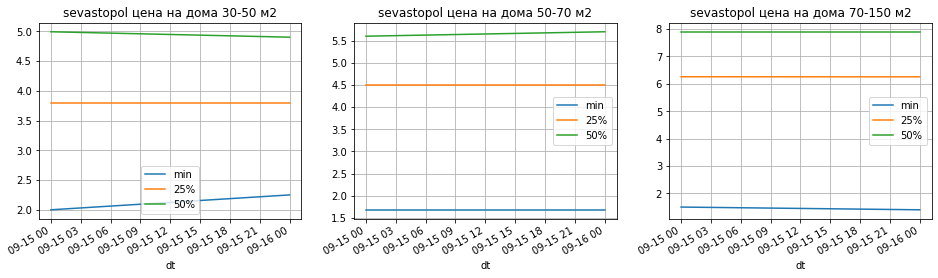

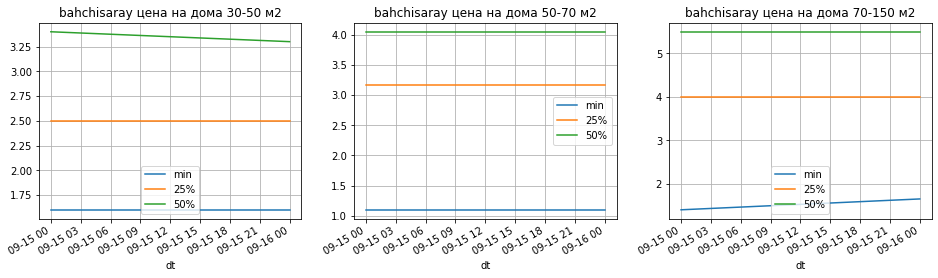

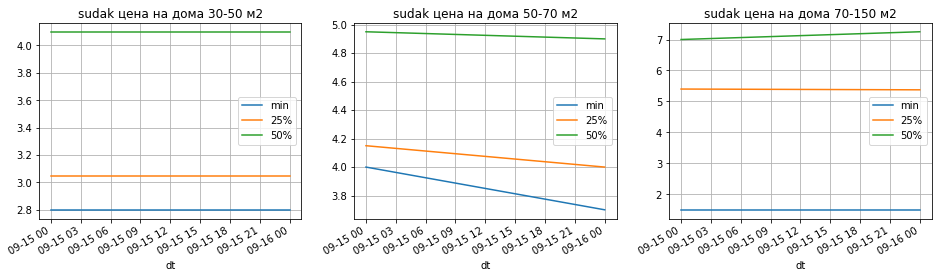

In [44]:
import matplotlib.pyplot as plt

sizes = ['30-50','50-70','70-150',]
places = gdf['place'].unique()
for p in places: 
    fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
    for i,s in enumerate(sizes): 
        stat.loc[(p,s),['min','25%','50%']].plot(grid=True, title=f'{p} цена на дома {s} м2',ax=ax[i])

## гексагональная сетка

In [45]:
places = gdf['place'].unique()
places

array(['sevastopol', 'bahchisaray', 'sudak'], dtype=object)

In [46]:
from shapely.geometry import MultiPoint

frame_geometry = gpd.GeoDataFrame([{ 
            'place':p, 
            'geometry':MultiPoint( gdf[gdf['place']==p]['geometry'].tolist() ).convex_hull, 
        } for p in places ]
    ,crs='EPSG:4326')

In [47]:
frame_geometry.explore('place',legend=True,cmap='rainbow')

In [48]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,place,cell_size=8,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({'place':place,'hex_id': hexs, 'geometry':list(map(polygonise, hexs)), },crs=crs,)

In [49]:
places = { # размеры сетки для разных мест
'sevastopol':6,
'sudak':8,
'bahchisaray':6,
}

grid = gpd.GeoDataFrame(
    pd.concat([
        cover_grid_hexagonal(frame_geometry[ frame_geometry['place']==p ]['geometry'].values[0],p,cell_size=cs)
        for p,cs in places.items()
        ], ignore_index=True)
    ,crs='EPSG:4326'
)

grid.explore('place',cmap='rainbow')

### медиана актуальной цены

In [50]:
place = ['bahchisaray',]

grid_ =  grid[grid['place'].isin(place)]

grid_values = (
   grid_.sjoin( gdf[ (gdf['dt']>ts) & (gdf['priceM']<15.) ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid_.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [51]:
place = ['sevastopol',]

grid_ =  grid[grid['place'].isin(place)]

grid_values = (
   grid_.sjoin( gdf[ (gdf['dt']>ts) & (gdf['priceM']<15.) ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid_.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [52]:
place = ['sudak',]

grid_ =  grid[grid['place'].isin(place)]

grid_values = (
   grid_.sjoin( gdf[ (gdf['dt']>ts) & (gdf['priceM']<15.) ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid_.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

---